<a href="https://colab.research.google.com/github/eniktab/MoE_nlp/blob/master/HelloMoE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

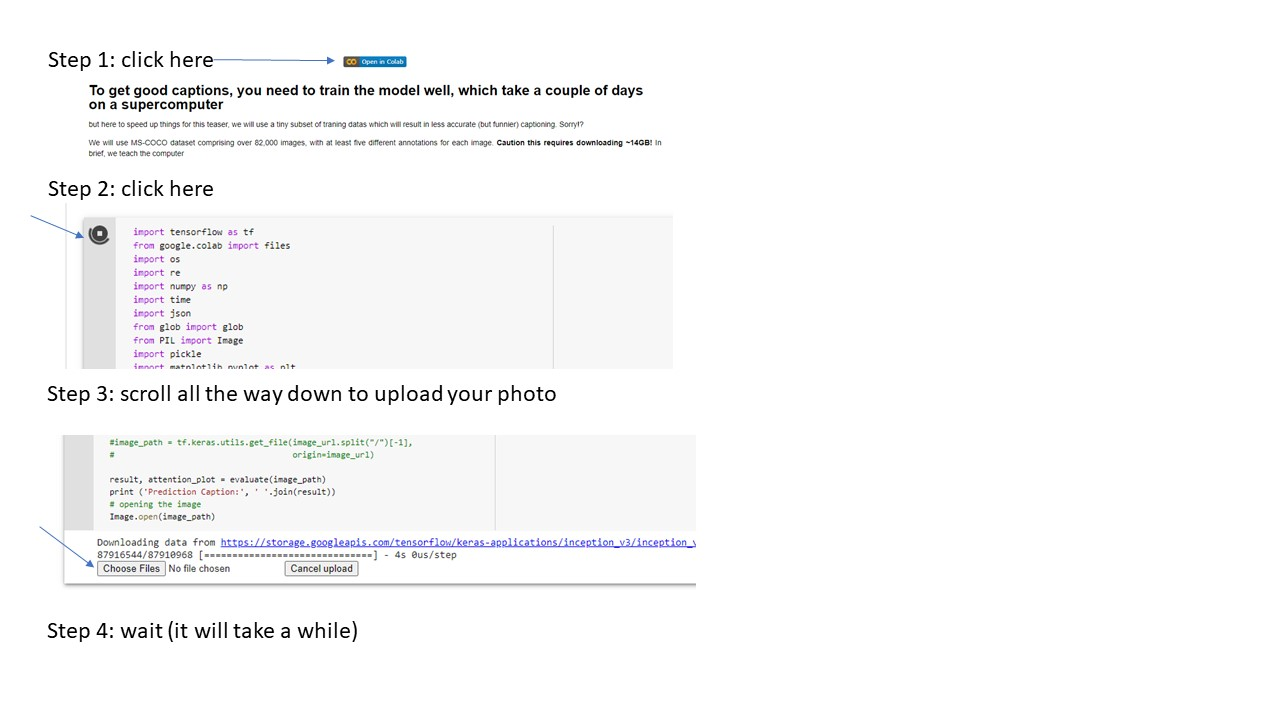

# **To get good captions, you need to train the model well, which take a couple of days on a supercomputer **
but here to speed up things for this teaser, we will use a tiny subset of traning datas which will result in less accurate (but funnier) captioning. Sorry!?

We will use MS-COCO dataset comprising over 82,000 images, with at least five different annotations for each image. 
In brief, we teach the computer
1.  to look at an image and turn it into a tensor (multidimensional matrix)
like [[2,4,....,2,1] ..... [1,3...]]
2.  decide what a sequence of number like [2,4,....,2,1] means
3.  learn to speak in English a tell us what it saw 





In [ ]:
  from google.colab import files
  import tensorflow as tf
  import os 

  def get_image_path(defualt_url=
                   'https://raw.githubusercontent.com/eniktab/MoE_nlp/main/1.jpg'):
    """ upload an image on the hard disk or get a file from url"""

    image_url = files.upload()
    # image_url= input("Set your image path: you can upload it at this website " \
    #                "\n get the link from --->>> https://imgur.com/upload \n " \
    #                "then copy past the link in this box --->>>  ")
    image_path = str(*image_url.keys())
    if len(image_path) < 1:
        print("Using the defualt image. Thank you Philip for your contribution!")
        image_path = defualt_url
        image_path = tf.keras.utils.get_file(defualt_url.split(r"/")[0],
                                             origin=defualt_url)
    return image_path

image_url = get_image_path()
os.environ["PATHURL"] = str(image_url)

!rm Caption.py
!wget https://raw.githubusercontent.com/eniktab/MoE_nlp/master/Caption.py
!python3 Caption.py $PATHURL